---
layout: default
title: "Machine learning diagnostic"
categories: evaluation
permalink: /ML17/
order: 17
comments: true
---

In [33]:
%pylab --no-import-all inline

import seaborn as sns
import pandas as pd
import sympy

Populating the interactive namespace from numpy and matplotlib


# Machine learning diagnostic

Suppose you have implemented a regularized linear regression to predict housing prices. So you have successfully minimized cost function $J(\theta)$

$$
J(\theta) = \frac{1}{2m} \left[ \sum_{i=1}^m \left(h_\theta\left(x^{(i)}\right) - y^{(i)}\right)^2 + \lambda \sum_{j=1}^m \theta_j^2 \right]
$$

However, suppose that when you test your hypothesis, it makes unacceptably large errors in its predictions. What should you do next? 

There are a number of things that you could do to improve the algorithm:

* Get more training examples
* Try a smallers set of features to prevent overfitting
* Try getting additional features
* Try adding polynomial features
* Decreasing or increasing $\lambda$

In this chapter we will focus on **machine learning diagnostic**: a test that can be run to gain insight on what is or is not working with a learning algorithm.

## Evaluating an hypothesis

In the case of house prices if we want to see how our hypothesis is performing we could just plot it. Since we have just one feature (the area of each house) we can plot the feature against the price.

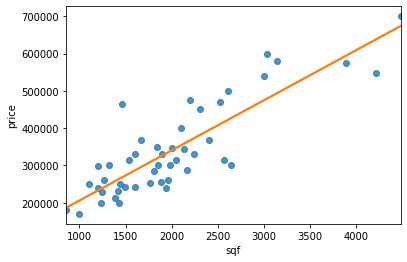

In [34]:
data = pd.read_csv('data/house_pricing.csv').drop('rooms', axis=1)
sns.regplot(data=data, x='sqf', y='price', ci=None, line_kws={'color': 'C1'});

When we have many features it becomes impossible to plot hypotheses. How do we tell if our hypothesis is overfitting? The standard way to evaluate a training hypothesis is to split the training set in two randomly selected subsets. The first subset ($70\%$ of the examples) will be the **training set** and the second subset ($30\%$ of the examples) will be the **test set** (blue background).

In [54]:
color = lambda s: ['background-color: lightskyblue' if s.name > 6 else '' for val in s]
data.head(10).style.hide_index().apply(color, axis=1)

sqf,price
2104,399900
1600,329900
2400,369000
1416,232000
3000,539900
1985,299900
1534,314900
1427,198999
1380,212000
1494,242500


And we will differentiate the notation between test set and training set as follows:

Training set:

$$
\begin{align}
&\left(x^{(1)}, y^{(1)} \right)\\
&\left(x^{(2)}, y^{(2)} \right)\\ 
& \quad \;\; \vdots \\ 
&\left(x^{(m)}, y^{(m)} \right)
\end{align}
\label{eq:trainingdata} \tag{1}
$$

Test set:

$$
\begin{align}
&\left(x^{(1)}_{\text{test}}, y^{(1)}_{\text{test}} \right)\\
&\left(x^{(2)}_{\text{test}}, y^{(2)}_{\text{test}} \right)\\ 
& \quad \;\; \vdots \\ 
&\left(x^{(m_\text{test})}_{\text{test}}, y^{(m_\text{test})}_{\text{test}} \right)
\end{align}
\label{eq:tetsdata} \tag{2}
$$

So here's how you will proceed with these two subsets: 

1. Learn paramters $\theta$ from the training set (minimizing error $J(\theta)$)
2. Compute test set error $J_\text{test}(\theta)$

In logistic regression you can of course compute $J_\text{test}(\theta)$ or alternatively you could compute the **misclassification error** (also called 0/1 misclassification error to convey that you can either classify an example correctly or incorrectly).

$$
\begin{equation}
\text{err}(h_\theta(x), y)=
\begin{cases}\!% alignment adjustment
&1 \quad
  \begin{aligned}[t]% adjust case condition placement here, use [t]op, [b]ottom, or [c]enter (default)
    &\text{if } h_\theta(x) \geq 0.5, \; y=0\\ 
    &\text{or } h_\theta(x) < 0.5, \; y=1\\
  \end{aligned} \\ \\
&0 \quad \text{otherwise}
\end{cases}
\end{equation}
$$

$$
\text{Test Error} = \frac{1}{m_\text{test}} \sum^{m_\text{test}}_{i=1} \text{err} \left( h_\theta\left( x^{(i)}_\text{test} \right), y^{(i)}_\text{test} \right)
$$

## Model selection
This section regards model selection problems. In particular we will touch upon how o choose the polynomial features to include in an hypothesis and how to choose the regularization paramter $\lambda$. 

To do this we will split the data not only in training and test sets but in three subsets. The **training-set**, the **test-set** and the **validation-set**.

Let's say that you are trying to chose what degree polynomial to fit to the data. It is as if  in our algorithm there is an extra parameter $d$ to set that represents what degree of polynomial we want to use.

$$
\begin{align}
d=1 \to \; & h_\theta(x) = \theta_0+\theta_1x & \to \theta^{(1)}\\
d=2 \to \; & h_\theta(x) = \theta_0+\theta_1x+\theta_2x^2 & \to \theta^{(2)}\\
d=3 \to \; & h_\theta(x) = \theta_0+\theta_1x+\dots+\theta_3x^3 & \to \theta^{(3)}\\
&\vdots &\\
d=10 \to \; & h_\theta(x) = \theta_0+\theta_1x+\dots+\theta_{10}x^{10} & \to \theta^{(10)}\\
\end{align}
$$

You want to choose a model, fit the model and get an estimate of how well the fitted model generalize on new examples. In order to chose a model we could be tempted to calculate the test-set error for each model with parameter $d$ and fitted parameters $\theta^{(i)}$ and chose the model with the smallest $J_\text{test}(\theta)$.

$$
\begin{align}
\theta^{(1)} \to \; & J_\text{test}\left(\theta^{(1)}\right)\\
\theta^{(2)} \to \; & J_\text{test}\left(\theta^{(2)}\right)\\
\theta^{(3)} \to \; & J_\text{test}\left(\theta^{(3)}\right)\\
&\vdots \\
\theta^{(10)} \to \; & J_\text{test}\left(\theta^{(10)}\right)\\
\end{align}
$$

However, the chosen $J_\text{test}(\theta^{(i)})$ is very likely to be an optimistic estimate of the generalization error because we fit the parameter $d$ to the test-set so it will tend to perform better on the test than on a general case.

In order to resolve this issue we are going to split our dataset in three subsets: training-set, the cross validation-set (or CV, orange background) and the test set (blue background). Usually the training set will take around $60\%$ of your dataset and the test and cross-validation sets will take $20\%$ each.

In [55]:
def color(s):
    colors = []
    for val in s:
        c = ''
        if s.name > 5:
            c = 'background-color: bisque'
        if s.name > 7:
            c= 'background-color: lightskyblue'
        colors.append(c)
    return colors
data.head(10).style.hide_index().apply(color, axis=1)

sqf,price
2104,399900
1600,329900
2400,369000
1416,232000
3000,539900
1985,299900
1534,314900
1427,198999
1380,212000
1494,242500


And of course now, in addition to $\eqref{eq:trainingdata}$ and $\eqref{eq:testdata}$  we will have:


$$
\begin{align}
&\left(x^{(1)}_{\text{CV}}, y^{(1)}_{\text{CV}} \right)\\
&\left(x^{(2)}_{\text{CV}}, y^{(2)}_{\text{CV}} \right)\\ 
& \quad \;\; \vdots \\ 
&\left(x^{(m_{CV})}_{\text{CV}}, y^{(m_{CV})}_{\text{CV}} \right)
\end{align}
$$

And we can also define the errors for the three subsets.

Training error

$$
J_\text{train}(\theta) = \frac{1}{2m}\sum^m_{i=1}\left(h_\theta\left(x^{(i)}\right) - y^{(i)}\right)^2
$$

Cross Validation error

$$
J_\text{CV}(\theta) = \frac{1}{2m_\text{CV}}\sum^{m_\text{CV}}_{i=1}\left(h_\theta\left(x_\text{CV}^{(i)}\right) - y_\text{CV}^{(i)}\right)^2
$$

Test error

$$
J_\text{test}(\theta) = \frac{1}{2m_\text{test}}\sum^{m_\text{test}}_{i=1}\left(h_\theta\left(x_\text{test}^{(i)}\right) - y_\text{test}^{(i)}\right)^2
$$

And so before testing the generalization power of you algorithm on the test set you can select the model that produces $\min_\theta J(\theta)$ calculated on the Cross Validation set.

While it is ill advised to optimizize $J_\text{test}(\theta)$ and $J_\text{CV}(\theta)$ on the same subset (test set), sometimes you will encounter algorithms trained in such a way. If the test is very big this should not be a problem but othwerise you should also have separate test and cross-validation sets.